<a href="https://colab.research.google.com/github/ludovicolc/Indeed_jobs_project/blob/main/indeed_jobs_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esplorazione & Analisi offerte di lavoro estratte da indeed.com 

### Obiettivo principale del progetto
Costruzione di un programma capace di estrarre informazioni chiave riguardo le offerte lavorative di un detrminato settore di interesse, allo scopo di  comprendere i punti principali su cui focalizzare la propria attenzione nella ricerca di una futura posizione lavorativa.

Nello specifico in questo progetto sono state analizzate le offerte relative al settore ''analisi dati'' in Italia, è comunque possibile variare luogo, settore e requisiti in base alle proprie preferenze. 

### Fasi del progetto
1.   Estrazione e trasformazione dati
2.   Rielaborazione DataFrame & Pulizia Dati
3.   Analisi dei dati


### Note importanti riguardo la raccolta dati da indeed.com
*   Per offrire un servizio migliore indeed esclude le offerte simili rilevate come duplicati, questo porta il numero di offerte effettivamente visualizzabili ad essere inferiore rispetto al numero di offerte totali dichiarate
*   In determinati casi indeed modifica la struttura html della pagina, per evitare di effettuare ricerche a vuoto è importante verificare in anticipo se gli elementi ricercati nella funzione transform() sono rimasti invariati
*   Il numero di richieste effettuabili ogni giorno su indeed per raccogliere dati è limitato, per questo motivo è necessario valutare correttamente che cosa ricercare prima di avviare il programma, infatti, dopo una serie di richieste o anche dopo appena 1 (se il quantitativo di dati è considerevole), la ricerca risulterà a vuoto.


# Libraries

In [139]:
# Scraping
import requests
from bs4 import BeautifulSoup as bs
import time
# Gestione dati
import pandas as pd
import numpy as np
# Visualizzazioni
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
sns.set_style("darkgrid")
sns.set_palette('viridis')

# 1. Estrazione e trasformazione dati
Note:
*   in country è necessario utilizzare TLD (Top Level Domain) es. Italia = it
*   indeed restituisce solo una parte delle offerte trovate ovvero 100 pagine circa, questo perchè un gran numero di esse vengono considerate come duplicati e quindi escluse, per implementare la ricerca è possibile aggiungere diverse parole chiave effettuando più estrazioni separate
*   se si vuole comprendere esclusivamente l'utilizzo del programma è consigliabile inserire un numero ristretto di chiavi di ricerca
*   radius identifica il raggio in cui cercare le offerte partendo da una posizione iniziale (città-regione) e può assumere i seguenti valori in km: 0, 10, 25, 50, 75, 100

*   la funzione cerca_per() può essere utilizzata in diversi modi attraverso delle semplici modifiche e assegnando determinati valori ai parametri richiesti, ad esempio si può creare una lista di località in cui effettuare la propria ricerca



(Parole chave utilizzate: 'data', 'business', 'dati', 'analista', 'analyst', 'financial', 'finanza')

In [ ]:
# Estrazione pagine
def extract(job, page, luogo='', country='it', radius=0):
    url = f'https://{country}.indeed.com/jobs?q={job}&l={luogo}&filter=0&start={page}&radius={radius}'
    response = sessione.get(url, headers=headers)
    soup = bs(response.content, 'html.parser')
    return soup

# Trasformazione pagine estratte (raccolta informazioni grezze) 
def transform(soup):
    divs = soup.find_all('div', class_ = 'slider_container css-g7s71f eu4oa1w0')

    for items in divs:
        posizione = items.find('a').text.strip()
        location = items.find('div', class_ = 'companyLocation').text.strip()
        azienda = items.find('span', class_ = 'companyName').text.strip()
        try:
            rating = items.find('span', class_ = 'ratingNumber').text
        except:
            rating = ''
        try:
            stipendio = items.find('div', class_ = 'metadata salary-snippet-container').get_text()
        except:
            stipendio = '' 
        link = 'https://it.indeed.com' + items.find('a', class_='jcs-JobTitle css-jspxzf eu4oa1w0').get('href')
        link_response = requests.get(link, headers=headers)
        link_soup = bs(link_response.content, 'html.parser')
        link_texts = link_soup.find('div', class_='jobsearch-JobComponent-description icl-u-xs-mt--md')
        if link_texts is not None:
            descrizione = link_texts.get_text(strip=True)
        else:
            descrizione = np.nan

        dati = {
            'Posizione': posizione,
            'Location': location,
            'Nome_azienda': azienda,
            'Rating_azienda': rating,
            'Stipendio': stipendio,
            'Descrizione': descrizione
        }
        jobs.append(dati)
    return

# Ricerca su diverse pagine
def cerca_per(chiave):
    page = 0
    while True: 
        ext = extract(job=chiave, page=page)
        transform(ext)
        if not ext.find('a', {'aria-label': 'Prossima'}):
            break
        page = page + 10

## Creazione DataFrame

In [ ]:
# Possono essere modificate 
chiavi_ricerca = ['data', 'business', 'dati', 'analista', 'analyst', 'financial', 'finanza']

In [ ]:
# Elementi base
sessione = requests.Session()
jobs = []
headers = {'User-Agent': 'Mozilla/5.0 (X11; CrOS x86_64 14816.82.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'}

In [ ]:
# Ricerca offerte
for chv in chiavi_ricerca:
    cerca_per(chv)
    time.sleep(10)

In [ ]:
# Creazione Dataframe
df_raw_joblist = pd.DataFrame(jobs)

Struttura Dataframe grezzo

In [ ]:
# Struttura
df_raw_joblist.shape

In [ ]:
df_raw_joblist.head()

,Posizione,Location,Nome_azienda,Rating_azienda,Stipendio,Descrizione
0,Scuderia AlphaTauri - Head of Legal,"Faenza, Emilia-Romagna",Red Bull,"4,0",,The Head of Legal will take over the overall r...
1,Business Analyst,"Milano, Lombardia",Parfums Christian Dior,"4,1",,Dettagli offerta di lavoroTipo di offerta di l...
2,Business development manager,"Rubiera, Emilia-Romagna",Tetra Pak,"4,2",,At Tetra Pak we commit to making food safe and...
3,Business Management M/F,"Catania, Sicilia",STMicroelectronics,"4,1",,Position descriptionPosting titleBusiness Mana...
4,University Student Ambassador,"Da remoto in Venezia, Veneto",EDUopinions,,€800 al mese,Dettagli offerta di lavoroStipendio€800 al mes...


In [ ]:
# Creazione file csv (grezzo)
df_raw_joblist.to_csv('indeed_data_df_grezzo.csv', index=False)

# 2. Rielaborazione DataFrame & Pulizia Dati

In [140]:
# Avvio Dataframe da rielaborare
df_joblist = pd.read_csv('/content/indeed_data_df_grezzo.csv')

### Posizione

In [141]:
# Pulizia e riordinamento di base
df_joblist['Posizione'] = df_joblist['Posizione'].str.strip()

### Location
Note:
*   per una migliore comprensione ed analisi le città sono state separate dalle proprie regioni di appartenenza creando 2 nuove colonne 



In [142]:
# Pulizia e riordinamento di base
df_joblist['Location'] = df_joblist['Location'].str.lower()

# Rimozione codice postale
str_range = [str(n) for n in [r for r in range(0, 10)]]
for x in str_range:
  df_joblist['Location'] = df_joblist['Location'].str.replace(x, '')

In [143]:
# Standardizzazione offerte 'da remoto'
for x in df_joblist['Location']:
    if 'da remoto' in x:
        df_joblist['Location'] = df_joblist['Location'].str.replace(x, 'da remoto, da remoto')

In [144]:
# Separazione città-regione
df_joblist['Città'], df_joblist['Regione'] = df_joblist['Location'].str.split(', ', 1).str

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


In [145]:
# Trasferimento regioni rimaste in colonna città
regioni = ['abruzzo', 'basilicata', 'calabria', 'campania', 'emilia-romagna', 'friuli-venezia giulia',
           'lazio', 'liguria', 'lombardia', 'marche', 'molise', 'piemonte', 'puglia', 'sardegna', 'sicilia',
           'toscana', 'trentino-alto adige', 'umbria', 'valle d\'aosta', 'veneto']

regioni_in_città = df_joblist[df_joblist['Città'].isin(regioni)].index.tolist()
for reg in regioni_in_città:
    df_joblist['Regione'][reg] = df_joblist['Città'][reg]
    df_joblist['Città'][reg] = np.nan

In [ ]:
# Osservare se presenti parole/simboli non coerenti
df_joblist['Città'].unique()

In [147]:
# Rimozione parole/simboli non coerenti
df_joblist['Città'] = df_joblist['Città'].str.replace('provincia di ', '').str.strip()

In [148]:
# Osservare se presenti parole/simboli non coerenti
df_joblist['Regione'].unique()

array(['emilia-romagna', 'lombardia', 'sicilia', 'da remoto', nan,
       'abruzzo', 'lazio', 'veneto', 'liguria', 'toscana', 'piemonte',
       'campania', 'puglia', 'marche', 'trentino-alto adige',
       'friuli-venezia giulia', 'sardegna', 'molise', 'umbria',
       'basilicata', 'calabria'], dtype=object)

In [149]:
# Rimozione parole/simboli non coerenti
df_joblist['Regione'] = df_joblist['Regione'].str.replace('\+ luogo', '').str.strip()
df_joblist['Regione'] = df_joblist['Regione'].str.replace('\+ luoghi', '').str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [150]:
# Eliminazione colonna 'Location'
df_joblist = df_joblist.drop(columns='Location')

### Nome_azienda

In [151]:
# Pulizia e riordinamento di base
df_joblist['Nome_azienda'] = df_joblist['Nome_azienda'].str.strip()

### Rating_azienda

In [152]:
# Pulizia e riordinamento di base
df_joblist['Rating_azienda'] = df_joblist['Rating_azienda'].str.replace(',', '.')
df_joblist['Rating_azienda'] = pd.to_numeric(df_joblist['Rating_azienda'])

### Stipendio

In [153]:
# Pulizia e riordinamento di base
rimuovere = ['€', '.', 'all\'anno', ' ']
for x in rimuovere:
    df_joblist['Stipendio'] = df_joblist['Stipendio'].str.replace(x, '') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


In [154]:
# Sostituzione virgola con punto per eventuali decimali
df_joblist['Stipendio'] = df_joblist['Stipendio'].str.replace(',', '.')

In [155]:
# Estrazione stipendio più elevato da range stipendi; es. 1000-1100 = 1100
for x in df_joblist['Stipendio'].astype(str):
    if '-' in x:
        df_joblist['Stipendio'] = df_joblist['Stipendio'].replace(x, x[x.index('-')+1:])

Conversione stipendi orari-giornalieri-mensili in annuali

Ipotesi di base:
*   da mensile ad annuale: 12 mesi in un anno
*   da giornaliero ad annuale: 22 giorni al mese
*   da orario ad annuale: 8 ore al giorno 



In [156]:
# Liste per identificare stipendi da convertire
index_m = df_joblist.index[df_joblist['Stipendio'].str.contains('almese', na=False)].tolist()
index_g = df_joblist.index[df_joblist['Stipendio'].str.contains('algiorno', na=False)].tolist()
index_o = df_joblist.index[df_joblist['Stipendio'].str.contains('all\'ora', na=False)].tolist()

In [157]:
# Rimozione unità di misura
df_joblist['Stipendio'] = df_joblist['Stipendio'].str.replace('almese', '')
df_joblist['Stipendio'] = df_joblist['Stipendio'].str.replace('algiorno', '')
df_joblist['Stipendio'] = df_joblist['Stipendio'].str.replace('all\'ora', '')

In [158]:
# Conversione in numerici
df_joblist['Stipendio'] = pd.to_numeric(df_joblist['Stipendio'])
# Conversione in annuali
df_joblist['Stipendio'][index_m] = df_joblist['Stipendio'][index_m] * 12
df_joblist['Stipendio'][index_g] = df_joblist['Stipendio'][index_g] * 264
df_joblist['Stipendio'][index_o] = df_joblist['Stipendio'][index_o] * 2112

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Descrizione

In [159]:
# Pulizia e riordinamento di base
df_joblist['Descrizione'] = df_joblist['Descrizione'].str.lower()

rimuovere = [',', '.', ':', ';', '/', '-']
for x in rimuovere:
    df_joblist['Descrizione'] = df_joblist['Descrizione'].str.replace(x, ' ') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


Ricerca esperienza richiesta 

In [160]:
# Creazione colonna Esperienza_in_anni
exp = []
for x in df_joblist['Descrizione'].astype(str):
    if ' anno ' in x:
        exp.append(x.split(' ')[x.split(' ').index('anno') - 1])
    elif ' anni ' in x:
        exp.append(x.split(' ')[x.split(' ').index('anni') - 1])
    elif ' year ' in x:
        exp.append(x.split(' ')[x.split(' ').index('year') - 1])
    elif ' years ' in x:
        exp.append(x.split(' ')[x.split(' ').index('years') - 1])
    elif ' years\' ' in x:
        exp.append(x.split(' ')[x.split(' ').index('years\'') - 1])
    elif ' year\'s ' in x:
        exp.append(x.split(' ')[x.split(' ').index('year\'s') - 1])
    else:
        exp.append(0)

# Sostituzione eventuali numeri 1-2 espressi in forma letterale
exp1 = [1 if e == 'un' or e == 'one' else e for e in exp]
exps = [2 if e == 'due' or e == 'two' else e for e in exp1]

df_joblist['Esperienza_in_anni'] = exps
# Conversione in valori numerici
df_joblist['Esperienza_in_anni'] = pd.to_numeric(df_joblist['Esperienza_in_anni'], errors ='coerce')

Ricerca requisiti richiesti

Note:
*   i requisiti_primari sono quelli che verrano poi esposti ed analizzati ed andranno a comprendere anche i requisiti_secondari grazie alla funzione union()
*   i requisiti_secondari rappresentano requisiti che, pur avendo una denominazione differente, nella sostanza possono essere assimilati ai requisiti_primari 
*   a scelta si possono aggiungere e rimuovere i vari requisiti ricercati, sia primari che secondari



In [161]:
# Funzione per identificare requisiti dentro le offerete
def identificare(requisito):
    vals = [] 
    for x in df_joblist['Descrizione'].astype(str):
      if x.count(f'{requisito}') > 0:
        vals.append('si')
      else:
        vals.append(np.nan) 
    df_joblist[f'{requisito}'] = vals

In [162]:
# Requisiti ricercati
requisiti_primari = ['laurea', 'inglese', 'excel', 'sql', 'python', ' r ', 'tableau', ' bi ']
requisiti_secondari = ['english', 'degree', 'business intelligence']
reqs = requisiti_primari + requisiti_secondari
for req in reqs:
    identificare(req)

In [163]:
# Funzione per unire colonne aventi stesso significato ma nomi differenti
def union(req_primario, req_secondario):
    global df_joblist
    df_joblist[f'{req_primario}'] = np.where((df_joblist[f'{req_primario}'] == 'no') & 
                                             (df_joblist[f'{req_secondario}'] == 'si'),
                                             'si', df_joblist[f'{req_primario}'])
    df_joblist = df_joblist.drop(columns=f'{req_secondario}')

In [164]:
# Coppie di requisiti da unire
unione = [('laurea', 'degree'), ('inglese', 'english'), (' bi ', 'business intelligence')]
for x, y in unione:
    union(x, y)

In [165]:
# Creazione colonna requisiti totali per posizione
df_joblist['Requisiti_tot'] = df_joblist.iloc[:, -8:-1].count(axis=1)

In [166]:
# Eliminazione colonna 'Descrizione'
df_joblist = df_joblist.drop(columns='Descrizione')

DataFrame rielaborato

In [167]:
df_joblist.head()

,Posizione,Nome_azienda,Rating_azienda,Stipendio,Città,Regione,Esperienza_in_anni,laurea,inglese,excel,sql,python,r,tableau,bi,Requisiti_tot
0,Scuderia AlphaTauri - Head of Legal,Red Bull,4.0,NaN,faenza,emilia-romagna,8.0,NaN,NaN,si,NaN,NaN,NaN,NaN,NaN,1
1,Business Analyst,Parfums Christian Dior,4.1,NaN,milano,lombardia,3.0,NaN,NaN,si,NaN,NaN,NaN,NaN,NaN,1
2,Business development manager,Tetra Pak,4.2,NaN,rubiera,emilia-romagna,0.0,NaN,NaN,si,NaN,NaN,NaN,NaN,NaN,1
3,Business Management M/F,STMicroelectronics,4.1,NaN,catania,sicilia,0.0,NaN,NaN,si,NaN,NaN,NaN,NaN,NaN,1
4,University Student Ambassador,EDUopinions,NaN,9600.0,da remoto,da remoto,0.0,NaN,NaN,si,NaN,NaN,NaN,NaN,NaN,1


In [168]:
# Creazione file csv (pulito e riorganizzato)
df_joblist.to_csv('indeed_data_df_pulito.csv', index=False)

# 3. Analisi dei dati

Struttura Dataframe rielaborato

In [169]:
# Struttura
df_joblist.shape

(7000, 16)

In [170]:
# Informazioni generiche
df_joblist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Posizione           7000 non-null   object 
 1   Nome_azienda        7000 non-null   object 
 2   Rating_azienda      4704 non-null   float64
 3   Stipendio           394 non-null    float64
 4   Città               7000 non-null   object 
 5   Regione             5982 non-null   object 
 6   Esperienza_in_anni  6205 non-null   float64
 7   laurea              2635 non-null   object 
 8   inglese             2636 non-null   object 
 9   excel               2244 non-null   object 
 10  sql                 915 non-null    object 
 11  python              425 non-null    object 
 12   r                  433 non-null    object 
 13  tableau             162 non-null    object 
 14   bi                 294 non-null    object 
 15  Requisiti_tot       7000 non-null   int64  
dtypes: flo

Visionare duplicati e valori nulli

In [171]:
# Duplicati
df_joblist.duplicated().sum()

1599

In [172]:
# Identificazione duplicati
df_joblist[df_joblist.duplicated(keep=False)]

,Posizione,Nome_azienda,Rating_azienda,Stipendio,Città,Regione,Esperienza_in_anni,laurea,inglese,excel,sql,python,r,tableau,bi,Requisiti_tot
0,Scuderia AlphaTauri - Head of Legal,Red Bull,4.0,NaN,faenza,emilia-romagna,8.0,NaN,NaN,si,NaN,NaN,NaN,NaN,NaN,1
1,Business Analyst,Parfums Christian Dior,4.1,NaN,milano,lombardia,3.0,NaN,NaN,si,NaN,NaN,NaN,NaN,NaN,1
3,Business Management M/F,STMicroelectronics,4.1,NaN,catania,sicilia,0.0,NaN,NaN,si,NaN,NaN,NaN,NaN,NaN,1
13,Business Development Analyst,Page Personnel Italia,2.6,35000.0,milano,lombardia,2.0,si,si,si,NaN,NaN,NaN,NaN,NaN,3
16,Senior Business Development Specialist for Cli...,South Pole,NaN,NaN,da remoto,da remoto,NaN,NaN,NaN,si,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6971,Business Manager,Adecco Italia,3.8,NaN,da remoto,da remoto,5.0,si,si,si,NaN,NaN,NaN,NaN,NaN,3
6978,Business Development Manager - Telecommunicati...,Alten,3.0,NaN,milano,lombardia,0.0,si,si,NaN,NaN,NaN,NaN,NaN,NaN,2
6983,"Senior Finance Manager, EU Private Brands, EU ...",Amazon EU SARL (Italy Branch),3.5,NaN,milano,lombardia,0.0,NaN,NaN,si,NaN,NaN,NaN,NaN,NaN,1
6985,Specialista Incassi,Adecco Italia,3.8,NaN,bologna,emilia-romagna,0.0,si,NaN,si,NaN,NaN,NaN,NaN,NaN,2


In [173]:
# Eliminazione duplicati
df_joblist.drop_duplicates(inplace=True)

In [174]:
# Valori nulli
df_joblist.isnull().sum()

Posizione                0
Nome_azienda             0
Rating_azienda        1845
Stipendio             5096
Città                    0
Regione                789
Esperienza_in_anni     595
laurea                3419
inglese               3424
excel                 3747
sql                   4713
python                5078
 r                    5094
tableau               5291
 bi                   5204
Requisiti_tot            0
dtype: int64

Prime osservazioni riguardanti i valori numerici

In [175]:
df_joblist.describe()

,Rating_azienda,Stipendio,Esperienza_in_anni,Requisiti_tot
count,3556.000000,305.000000,4806.000000,5401.000000
mean,3.718926,40538.309377,3.852268,1.303647
std,0.423041,22034.484460,33.384535,1.079954
min,1.000000,5400.000000,0.000000,0.000000
25%,3.500000,31000.000000,0.000000,1.000000
50%,3.800000,37000.000000,0.000000,1.000000
75%,4.000000,45000.000000,3.000000,2.000000
max,5.000000,160000.000000,2020.000000,7.000000


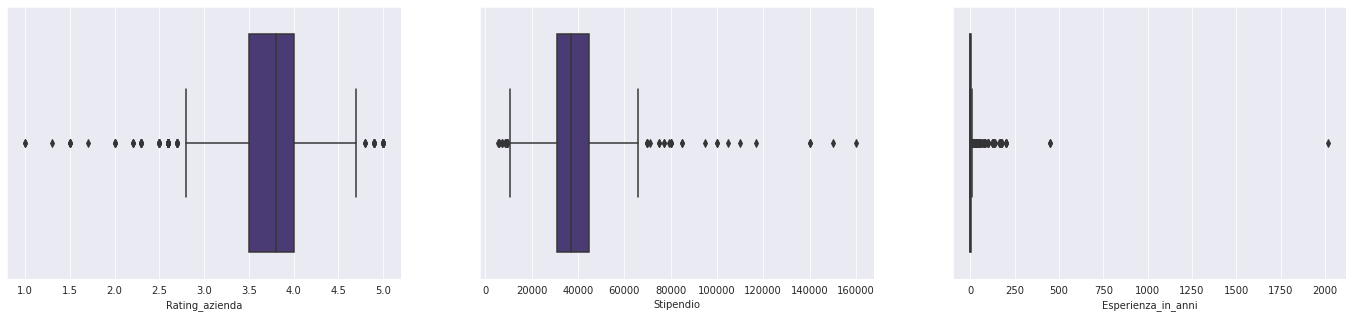

In [176]:
# Distribuzione principali valori numerici
fig, axs = plt.subplots(ncols=3, figsize=(24, 5))
sns.boxplot(x='Rating_azienda', data=df_joblist, ax=axs[0])
sns.boxplot(x='Stipendio', data=df_joblist, ax=axs[1])
sns.boxplot(x='Esperienza_in_anni', data=df_joblist, ax=axs[2])

Come si può osservare dal boxplot, la colonna 'Esperienza_in_anni' detiene un'elevata presenza di outliers, il motivo principale deriva dalla funzione utilizzata per l'estrazione del numero di anni che riporta anche, in alcuni casi, gli anni di attività dell'azienda offerente.
Ossevazioni e interventi:
*   generalmente l'esperienza richiesta va da un minimo di 0 anni fino ad un massimo di circa 10 anni
*   tipicamente le aziende che mostrano gli anni di attività sono quelle più mature (anni > 10)
*   in alcuni casi l'esperienza non viene esplicitata in numero di anni ma viene richiesta per alcune posizioni in modo generico (principalmente quando si tratta di una posizione di 'grado' elevato)
*   per rendere il campione statistico il più rilevante possibile sono stati rimossi gli outliers attraverso l'utilizzo del metodo IQR con 3 deviazioni standard

In [177]:
# Identificazione quartili e IQR
Q1_exp = df_joblist['Esperienza_in_anni'].quantile(0.25)
Q3_exp = df_joblist['Esperienza_in_anni'].quantile(0.75)
IQR_exp = Q3_exp - Q1_exp

In [178]:
# Assegnazione valori nulli agli outliers
for exp in df_joblist['Esperienza_in_anni']:
    if exp < (Q1_exp - 1.7 * IQR_exp):
        df_joblist['Esperienza_in_anni'] = df_joblist['Esperienza_in_anni'].replace(exp, np.nan)
    elif exp > (Q3_exp + 1.7 * IQR_exp):
        df_joblist['Esperienza_in_anni'] = df_joblist['Esperienza_in_anni'].replace(exp, np.nan)

In [179]:
df_joblist.describe()

,Rating_azienda,Stipendio,Esperienza_in_anni,Requisiti_tot
count,3556.000000,305.000000,4552.000000,5401.000000
mean,3.718926,40538.309377,1.153559,1.303647
std,0.423041,22034.484460,1.870780,1.079954
min,1.000000,5400.000000,0.000000,0.000000
25%,3.500000,31000.000000,0.000000,1.000000
50%,3.800000,37000.000000,0.000000,1.000000
75%,4.000000,45000.000000,2.000000,2.000000
max,5.000000,160000.000000,8.000000,7.000000


Visualizzazione delle parole più ricorrenti all'interno delle offerte di lavoro

In [180]:
# Creazione testo contenente tutte le posizioni
parole = ''.join([x.lower()+' ' for x in df_joblist['Posizione']])

In [181]:
# Creazione wordcloud
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 2000, height = 800, background_color ='black', 
                      colormap='viridis', stopwords = stopwords,
                      min_font_size = 10).generate(parole)

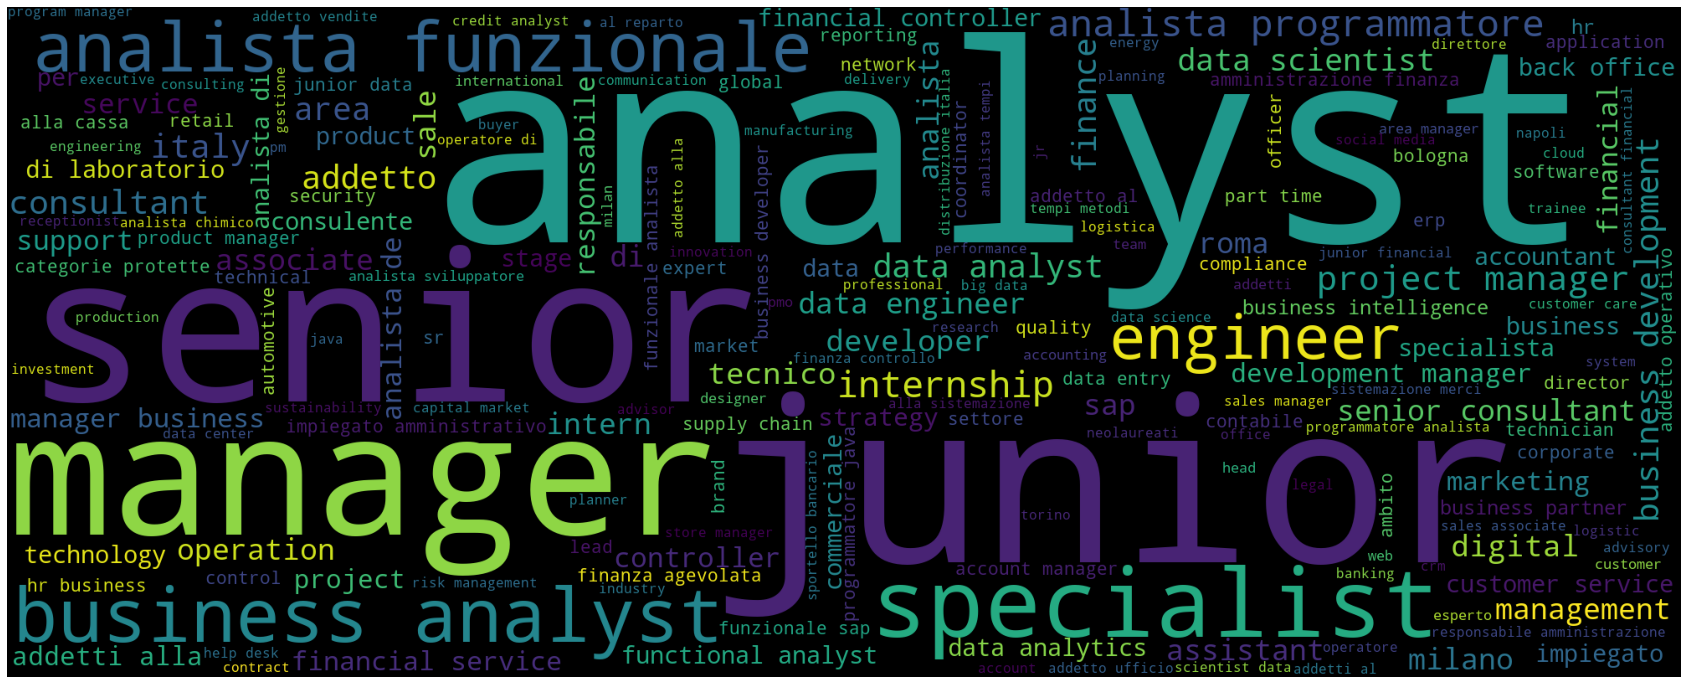

In [182]:
# Visualizzazione wordcloud
plt.figure(figsize = (30, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Osservazione offerte in termini di qualità aziendale (Rating_azienda) e Stipendio 

In [183]:
# Offerta/e con rating massimo
df_joblist[df_joblist['Rating_azienda'] == df_joblist['Rating_azienda'].max()]

,Posizione,Nome_azienda,Rating_azienda,Stipendio,Città,Regione,Esperienza_in_anni,laurea,inglese,excel,sql,python,r,tableau,bi,Requisiti_tot
727,Junior Digital Marketing,Virvelle,5.0,NaN,salerno,campania,0.0,si,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2040,Receptionist,Gruppo Inventa,5.0,NaN,pozzallo,sicilia,NaN,NaN,si,NaN,NaN,NaN,NaN,NaN,NaN,1
2077,Addetto/a alla Logistica,Virvelle,5.0,NaN,salerno,campania,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2518,Accountability Officer,ActionAid International Italia Onlus,5.0,NaN,da remoto,da remoto,3.0,NaN,si,NaN,NaN,NaN,NaN,NaN,NaN,1
2523,Ricerchiamo NEO-LAUREATO GIURISPRUDENZA - N.B....,I.T.Svil,5.0,NaN,salerno,NaN,0.0,si,si,NaN,NaN,NaN,NaN,NaN,NaN,2
2630,Operaio/a di produzione,Virvelle,5.0,NaN,capezzano,campania,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2718,Responsabile Tecnico,Virvelle,5.0,NaN,montoro inferiore,campania,0.0,si,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2723,Assistente Medico Competente,Virvelle,5.0,NaN,sarno,campania,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2879,Giardiniere,Virvelle,5.0,NaN,vietri sul mare,campania,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3621,Analisti Programmatori con almeno 3 anni di es...,I.T.Svil,5.0,NaN,salerno,NaN,3.0,NaN,NaN,NaN,si,NaN,NaN,NaN,NaN,1


In [184]:
# Offerta/e con rating minimo
df_joblist[df_joblist['Rating_azienda'] == df_joblist['Rating_azienda'].min()]

,Posizione,Nome_azienda,Rating_azienda,Stipendio,Città,Regione,Esperienza_in_anni,laurea,inglese,excel,sql,python,r,tableau,bi,Requisiti_tot
2986,SISTEMISTA MICROSOFT,Energent,1.0,NaN,roma,lazio,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4207,SECURITY ANALYST,Energent,1.0,NaN,milano,lombardia,7.0,NaN,si,NaN,NaN,NaN,NaN,NaN,NaN,1


In [185]:
# Offerta/e con stipendio massimo
df_joblist[df_joblist['Stipendio'] == df_joblist['Stipendio'].max()]

,Posizione,Nome_azienda,Rating_azienda,Stipendio,Città,Regione,Esperienza_in_anni,laurea,inglese,excel,sql,python,r,tableau,bi,Requisiti_tot
6072,AMMINISTRATORE DELEGATO,Profili e Carriere,NaN,160000.0,bergamo,lombardia,0.0,NaN,si,NaN,NaN,NaN,NaN,NaN,NaN,1


In [186]:
# Offerta/e con stipendio minimo
df_joblist[df_joblist['Stipendio'] == df_joblist['Stipendio'].min()]

,Posizione,Nome_azienda,Rating_azienda,Stipendio,Città,Regione,Esperienza_in_anni,laurea,inglese,excel,sql,python,r,tableau,bi,Requisiti_tot
6886,commerciale ufficio gare e contratti,Credit Network & Finance,2.2,5400.0,verona,NaN,0.0,si,NaN,si,NaN,NaN,NaN,NaN,NaN,2


Quante offerte richiedono esperienza (anche minima) e quante offerte mostrano lo Stipendio che verrà corrisposto

In [187]:
# Percentuale di offerte che richiedono esperienza di almeno 1 anno
round(df_joblist[df_joblist['Esperienza_in_anni'] > 0]['Esperienza_in_anni'].count() / (df_joblist.index.max()+1), 3)

0.223

In [188]:
# Percentuale di offerte che mostrano lo stipendio
round(df_joblist['Stipendio'].count() / (df_joblist.index.max()+1), 3)

0.044

Distribuzione offerte di lavoro in base alle regioni italiane e principali città che offrono le maggiori opportunità lavorative

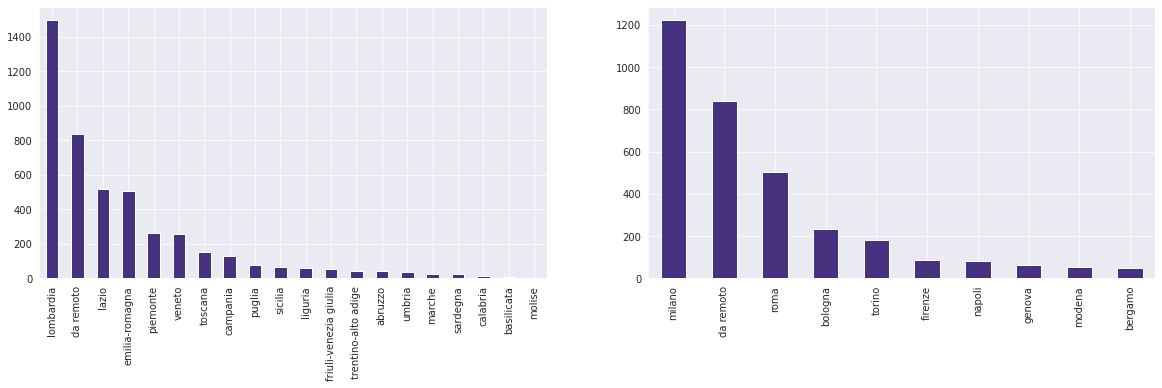

In [189]:
# Offerte lavorative per città e regione
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
plt.xticks(rotation=90)
df_joblist['Regione'].value_counts().plot(kind='bar', ax=axs[0])
# Città: top 10 
df_joblist['Città'].value_counts().head(10).plot(kind='bar')

Distribuzione valori principali per regione
*   stipendio
*   requisiti totali richiesti
*   esperienza 







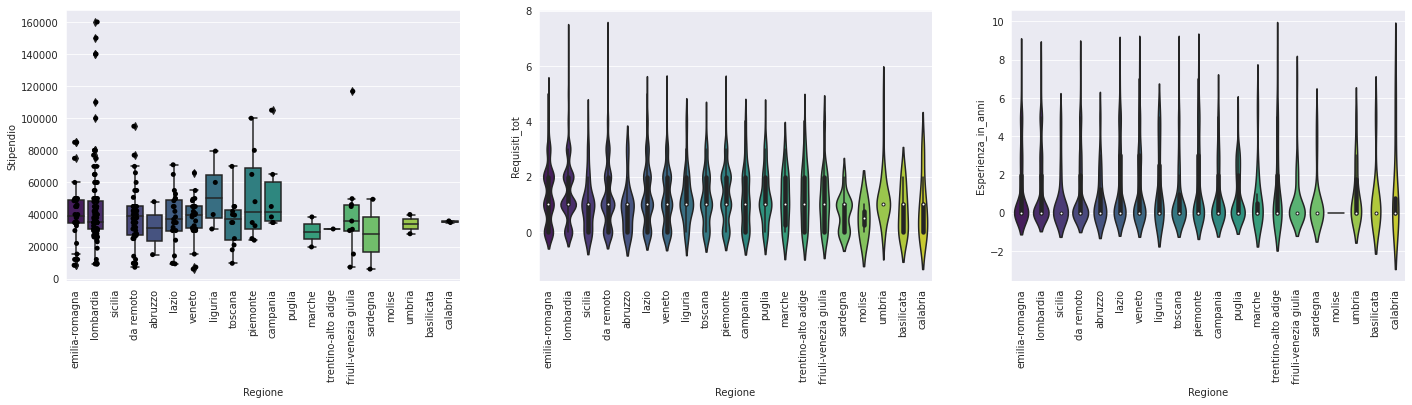

In [191]:
fig, axs = plt.subplots(ncols=3, figsize=(24, 5))
# Stipendi per regione
sns.boxplot(x='Regione', y='Stipendio', data=df_joblist, ax=axs[0], palette='viridis').tick_params('x', labelrotation=90)
sns.stripplot(x='Regione', y='Stipendio', data=df_joblist, color='black', jitter=True, ax=axs[0])
# Requisiti_tot per regione
sns.violinplot(x='Regione', y='Requisiti_tot', data=df_joblist, ax=axs[1], palette='viridis').tick_params('x', labelrotation=90)
# Esperienza_in_anni per regione
sns.violinplot(x='Regione', y='Esperienza_in_anni', data=df_joblist, ax=axs[2], palette='viridis').tick_params('x', labelrotation=90)

Raggruppamento regioni per area di appartenenza (Nord-Centro-Sud) e individuazione delle caratteristiche principali per ogni segmentazione



In [192]:
# Raggruppamento regioni per area
Nord = ['emilia-romagna', 'friuli-venezia giulia', 'liguria', 'lombardia',
        'piemonte', 'trentino-alto adige', 'valle d\'aosta', 'veneto']
Centro = ['toscana',  'umbria', 'lazio', 'marche']
Sud = ['abruzzo', 'basilicata', 'calabria', 'campania', 
       'molise', 'puglia', 'sardegna', 'sicilia']
# Creazione dataframe con suddivsione regioni per area di appartenenza
df_territorio = df_joblist[['Regione', 'Stipendio', 'Requisiti_tot', 'Esperienza_in_anni']]

In [193]:
# Assegnazione area appartenenza
for reg in df_territorio['Regione']:
    if reg in Nord:
        df_territorio['Regione'] = df_territorio['Regione'].replace(reg, 'nord')
    if reg in Centro:
        df_territorio['Regione'] = df_territorio['Regione'].replace(reg, 'centro')
    if reg in Sud:
        df_territorio['Regione'] = df_territorio['Regione'].replace(reg, 'sud')

df_territorio = df_territorio.rename(columns={'Regione': 'Area'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

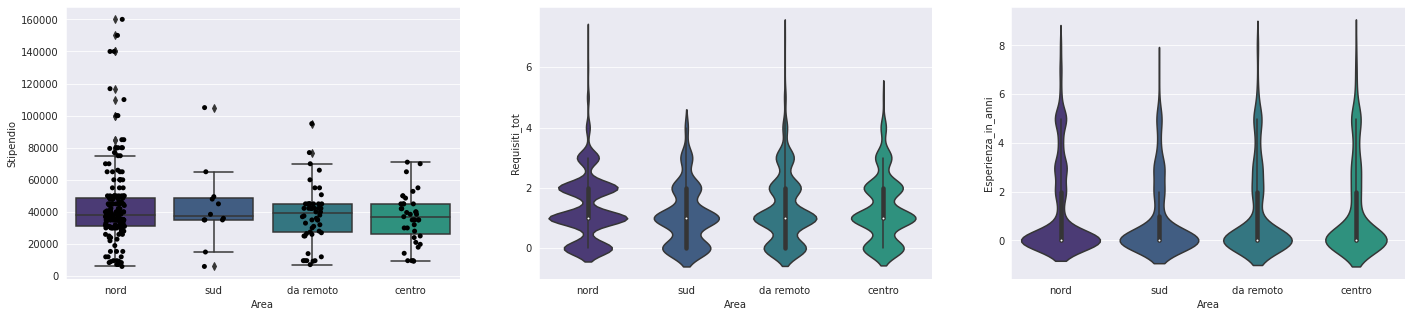

In [194]:
fig, axs = plt.subplots(ncols=3, figsize=(24, 5))
# Stipendio per area
sns.boxplot(x='Area', y='Stipendio', data=df_territorio, ax=axs[0])
sns.stripplot(x='Area', y='Stipendio', data=df_territorio, color='black', ax=axs[0], jitter=True)
# Requisiti_tot per area
sns.violinplot(x='Area', y='Requisiti_tot', data=df_territorio, ax=axs[1])
# Esperienza_in_anni per area
sns.violinplot(x='Area', y='Esperienza_in_anni', data=df_territorio, ax=axs[2])

Verifica presenza correlazioni tra i vari elementi del Dataframe

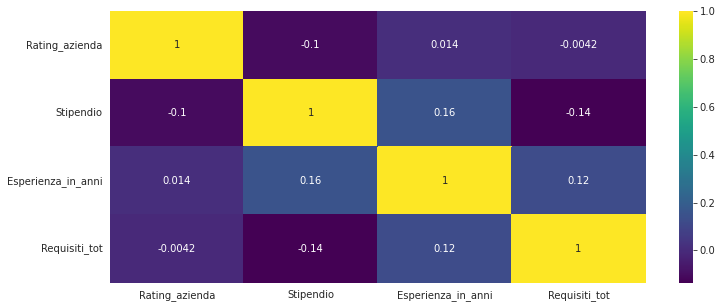

In [195]:
# Correlazioni tra i valori numerici
plt.figure(figsize=(12, 5))
sns.heatmap(data=df_joblist.corr(), cmap='viridis', annot=True)

Approfondimento requisiti richiesti

In [196]:
# Creazione Dataframe requisiti 
df_requisiti = pd.DataFrame({'requisiti': requisiti_primari,
                             'conteggio': [df_joblist[f'{req}'].count() for req in requisiti_primari]})

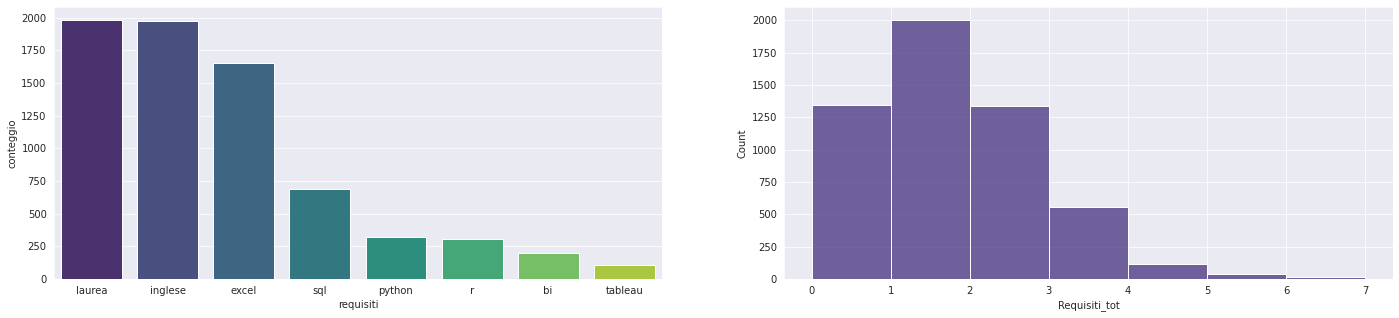

In [197]:
# Visualizzazione requisiti
fig, axs = plt.subplots(ncols=2, figsize=(24, 5))
sns.barplot(x='requisiti', y='conteggio', data=df_requisiti.sort_values(by=['conteggio'], ascending=False), ax = axs[0], palette='viridis')
sns.histplot(x='Requisiti_tot', data=df_joblist, binwidth=1)